In [16]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from google.colab import drive
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout, concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
import itertools
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 500
print("Tensorflow Hub Version: ", hub.__version__)

SEED = 42

module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/4'
USE_embed = hub.KerasLayer(module_url, trainable=False, name='USE_embedding')
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/MyDrive/alldata.csv")
df = df[df.Component != 'Other']
df = df.sample(frac = 1)
train, test = train_test_split(df, test_size=0.2)


Tensorflow Hub Version:  0.12.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
#df.head()
#df['Component'].unique()

In [18]:
train_embeddings = USE_embed(train.Component)['outputs'].numpy()

kmeans = KMeans(n_clusters=len(list(df["Component"].unique())), random_state=SEED).fit(train_embeddings)
train.loc[:,'Clusters'] = None
train.loc[:,'Clusters'] = kmeans.labels_

#display(train.sort_values(by = 'Component'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ConvergenceWarning: Number of distinct clusters (156) found smaller than n_clusters (160). Possibly due to duplicate points in X.
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(train.Component, kmeans.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(train.Component, kmeans.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(train.Component, kmeans.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(train.Component, kmeans.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(train_embeddings, train.Component, sample_size=1000))

#display(pd.crosstab(train['Clusters'], train['Component']))

Homogeneity: 1.000
Completeness: 0.989
V-measure: 0.994
Adjusted Rand-Index: 0.964
Silhouette Coefficient: 0.962


In [20]:
def kmeans_predict(text_input, fitted_kmeans):
    tmp_embd = USE_embed([text_input])['outputs'].numpy()
    return fitted_kmeans.predict(tmp_embd)[0]

test["Clusters"] = test.Summary.apply(lambda t: kmeans_predict(text_input=t,fitted_kmeans=kmeans))
#display(pd.crosstab(test['Clusters'], test['Component']))

In [21]:
dic = {}
l = ['Platform_x86', 'Bluetooth', 'SCSI', 'Network', 'network-wireless',
       'Serial ATA', 'v4l-other', 'Video(Other)', 'MD', 'kvm', 'USB',
       'Sound(ALSA)', 'Infiniband/RDMA', 'em28xx',
       'Video(DRI - non Intel)', 'Platform', 'ARM', 'IOMMU',
       'Netfilter/Iptables', 'network-wireless-intel', 'Watchdog', 'i386',
       'Wireless', 'mm', 'Flash/Memory Technology Devices', 'btrfs',
       'Bug Tracker', 'Serial', 'man-pages', 'IPV6', 'Perf tool', 'SysFS',
       'CIFS', 'ACPICA-Core', 'PCI', 'NFS', 'Block Layer',
       'Trace-cmd/Kernelshark', 'Input Devices', 'MMC/SD',
       'Power-Processor', 'PPC-32', 'VFS', 'pm-graph', 'IA-64', 'x86-64',
       'Modules', 'Scheduler', 'v4l-core', 'I2C', 'IPV4', 'cx88', 'ext4',
       'NVMe', 'Configuration', 'Staging', 'Hardware Monitoring',
       'Kernel Perf', 'SPARC64', 'lguest', 'Xen', 'rt', 'ReiserFS',
       'Sanitizers', 'XFS', 'Spam', 'webcam', 'QLOGIC QLA2XXX', 'Boot',
       'Page Allocator', 'EC', 'AFFS', 'dvb-usb', 'JFS', 'Power-Other',
       'DC390', 'Backports', 'ext3', 'f2fs', 'Power-Off', 'dvb-frontend',
       'Video(AGP)', 'Console/Framebuffers', 'BIOS', 'Ftrace',
       'Slab Allocator', 'Config-Other', 'ecryptfs', 'HotPlug', 'AACRAID',
       'IEEE1394', 'Realtime Clock', 'dvb-other',
       'Loadable Security Modules (LSM)', 'Samba/SMB', 'Power-Battery',
       'IDE', 'Power-Sleep-Wake', 'Preemption', 'cpuidle',
       'Hibernation/Suspend', 'AIO', 'KUnit', 'LVM2/DM', 'dvb-core',
       'FAT/VFAT/MSDOS', 'cpufreq', 'Sound(OSS)', 'devfs', 'gettimeofday',
       'Config-Hotplug', 'radio', 'Interval Timers', 'HFS/HFSPLUS', 'mjb',
       'Video', 'bt8xx', 'Thermal', 'UML', 'PPC-64', 'Video(DRI - Intel)',
       'ocfs2', 'EDAC', 'ISDN', 'klibc/kinit', 'Power-Video',
       'Config-Tables', 'v9fs', 'ttpci', 'intel_pstate', 'W1', 'MIPS',
       'Parallel', 'Config-Interrupts', 'PCMCIA', 'MTTR', 'squashfs',
       'intel_idle', 'Power-Lid', 'UDF', 'module-init-tools', 'AIC94XX',
       'ext2', 'NUMA/discontigmem', 'Config-Processors', 'gfs2', 'DIO',
       'PA-RISC', 'saa7134', 'Power-Thermal', 'sym53c8xx', 'PNP',
       'Power-Fan', 'S390', 'IIO', 'Alpha', 'Run-Time-PM', 'File Locking',
       'Sparse', 'DC395X']
for i in range(0,len(l)):
  dic[l[i]] = i
df['labels'] = df['Component'].map(dic)
class_names = l
train_data = df.loc[df.labels.notnull(),:].reset_index().copy()
train_data['labels'] = train_data['labels'].astype(int)
train_data['Summary'] = train_data['Summary'].astype(str)

categorical_labels = to_categorical(train_data['labels'].values, num_classes=None)
output_size = categorical_labels.shape[1]

print('Inpus Shape: {}, Output Shape: {}'.format(train_data['Summary'].shape, categorical_labels.shape))

Inpus Shape: (8096,), Output Shape: (8096, 160)


In [22]:
def build_model(embed, output_size=output_size):
    
    model = Sequential([
        Input(shape=[], dtype=tf.string),
        embed,
        Dense(output_size, activation='softmax')
    ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = build_model(USE_embed)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE_embedding (KerasLayer)  {'outputs': (None, 512)}  147354880 
                                                                 
 dense (Dense)               (None, 160)               82080     
                                                                 
Total params: 147,436,960
Trainable params: 82,080
Non-trainable params: 147,354,880
_________________________________________________________________


Epoch 1/40
900/900 [==============================] - 71s 52ms/step - loss: 4.0737 - accuracy: 0.2500 - val_loss: 3.5282 - val_accuracy: 0.3097
Epoch 2/40
900/900 [==============================] - 39s 43ms/step - loss: 3.3259 - accuracy: 0.3079 - val_loss: 3.1758 - val_accuracy: 0.3557
Epoch 3/40
900/900 [==============================] - 39s 43ms/step - loss: 3.0166 - accuracy: 0.3600 - val_loss: 2.9816 - val_accuracy: 0.3920
Epoch 4/40
900/900 [==============================] - 39s 43ms/step - loss: 2.8059 - accuracy: 0.3967 - val_loss: 2.8510 - val_accuracy: 0.4098
Epoch 5/40
900/900 [==============================] - 39s 43ms/step - loss: 2.6450 - accuracy: 0.4213 - val_loss: 2.7568 - val_accuracy: 0.4231
Epoch 6/40
900/900 [==============================] - 39s 43ms/step - loss: 2.5154 - accuracy: 0.4388 - val_loss: 2.6870 - val_accuracy: 0.4346
Epoch 7/40
900/900 [==============================] - 40s 44ms/step - loss: 2.4073 - accuracy: 0.4558 - val_loss: 2.6347 - val_accuracy:

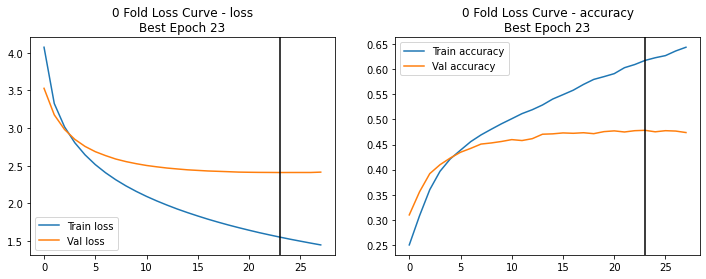

Epoch 1/40
900/900 [==============================] - 54s 50ms/step - loss: 4.0377 - accuracy: 0.2505 - val_loss: 3.6030 - val_accuracy: 0.2742
Epoch 2/40
900/900 [==============================] - 38s 42ms/step - loss: 3.2705 - accuracy: 0.3233 - val_loss: 3.2749 - val_accuracy: 0.3205
Epoch 3/40
900/900 [==============================] - 38s 42ms/step - loss: 2.9573 - accuracy: 0.3737 - val_loss: 3.0930 - val_accuracy: 0.3631
Epoch 4/40
900/900 [==============================] - 38s 42ms/step - loss: 2.7469 - accuracy: 0.4113 - val_loss: 2.9710 - val_accuracy: 0.3846
Epoch 5/40
900/900 [==============================] - 38s 42ms/step - loss: 2.5876 - accuracy: 0.4378 - val_loss: 2.8846 - val_accuracy: 0.3979
Epoch 6/40
900/900 [==============================] - 38s 42ms/step - loss: 2.4598 - accuracy: 0.4597 - val_loss: 2.8190 - val_accuracy: 0.4079
Epoch 7/40
900/900 [==============================] - 38s 42ms/step - loss: 2.3537 - accuracy: 0.4712 - val_loss: 2.7672 - val_accuracy:

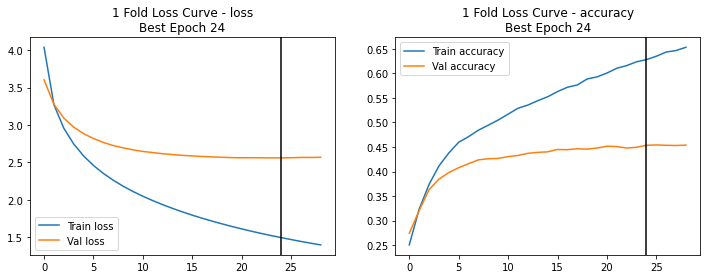

Epoch 1/40
900/900 [==============================] - 55s 50ms/step - loss: 4.0745 - accuracy: 0.2642 - val_loss: 3.5742 - val_accuracy: 0.2865
Epoch 2/40
900/900 [==============================] - 36s 40ms/step - loss: 3.3063 - accuracy: 0.3218 - val_loss: 3.2258 - val_accuracy: 0.3265
Epoch 3/40
900/900 [==============================] - 38s 42ms/step - loss: 2.9944 - accuracy: 0.3646 - val_loss: 3.0302 - val_accuracy: 0.3662
Epoch 4/40
900/900 [==============================] - 39s 43ms/step - loss: 2.7844 - accuracy: 0.4020 - val_loss: 2.8991 - val_accuracy: 0.3899
Epoch 5/40
900/900 [==============================] - 36s 40ms/step - loss: 2.6254 - accuracy: 0.4263 - val_loss: 2.8052 - val_accuracy: 0.4010
Epoch 6/40
900/900 [==============================] - 36s 40ms/step - loss: 2.4969 - accuracy: 0.4441 - val_loss: 2.7343 - val_accuracy: 0.4140
Epoch 7/40
900/900 [==============================] - 36s 40ms/step - loss: 2.3901 - accuracy: 0.4618 - val_loss: 2.6787 - val_accuracy:

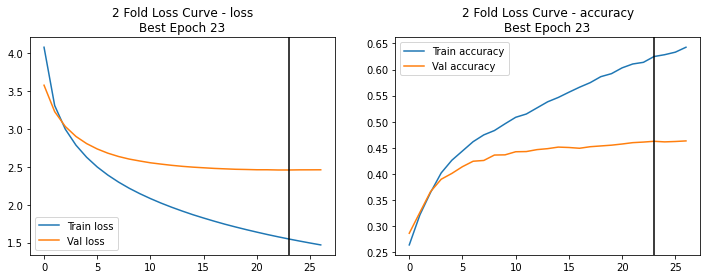

In [23]:
oof_preds = np.zeros([train_data.shape[0], output_size])

n_splits = 3
folds = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
plot_metrics = ['loss','accuracy']

fold_hist = {}
for i, (trn_idx, val_idx) in enumerate(folds.split(train_data)):
    model = build_model(USE_embed)
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1,
                                 mode='min', baseline=None, restore_best_weights=True)
    
    history = model.fit(
        train_data.Summary[trn_idx].values,
        categorical_labels[trn_idx],
        validation_data=(
            train_data.Summary[val_idx].values,
            categorical_labels[val_idx]),
        epochs=40,
        batch_size=6,
        callbacks = [es],
        verbose=1)
    
    best_index = np.argmin(history.history['val_loss'])
    fold_hist[i] = history
    
    oof_preds[val_idx] = model.predict(train_data.Summary[val_idx].values)
    
    f, ax = plt.subplots(1,len(plot_metrics),figsize = [12,4])
    for p_i,metric in enumerate(plot_metrics):
        ax[p_i].plot(history.history[metric], label='Train ' + metric)
        ax[p_i].plot(history.history['val_' + metric], label='Val ' + metric)
        ax[p_i].set_title("{} Fold Loss Curve - {}\nBest Epoch {}".format(i, metric, best_index))
        ax[p_i].legend()
        ax[p_i].axvline(x=best_index, c='black')
    plt.show()

In [29]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Accuracy: 0.46
Confusion Matrix


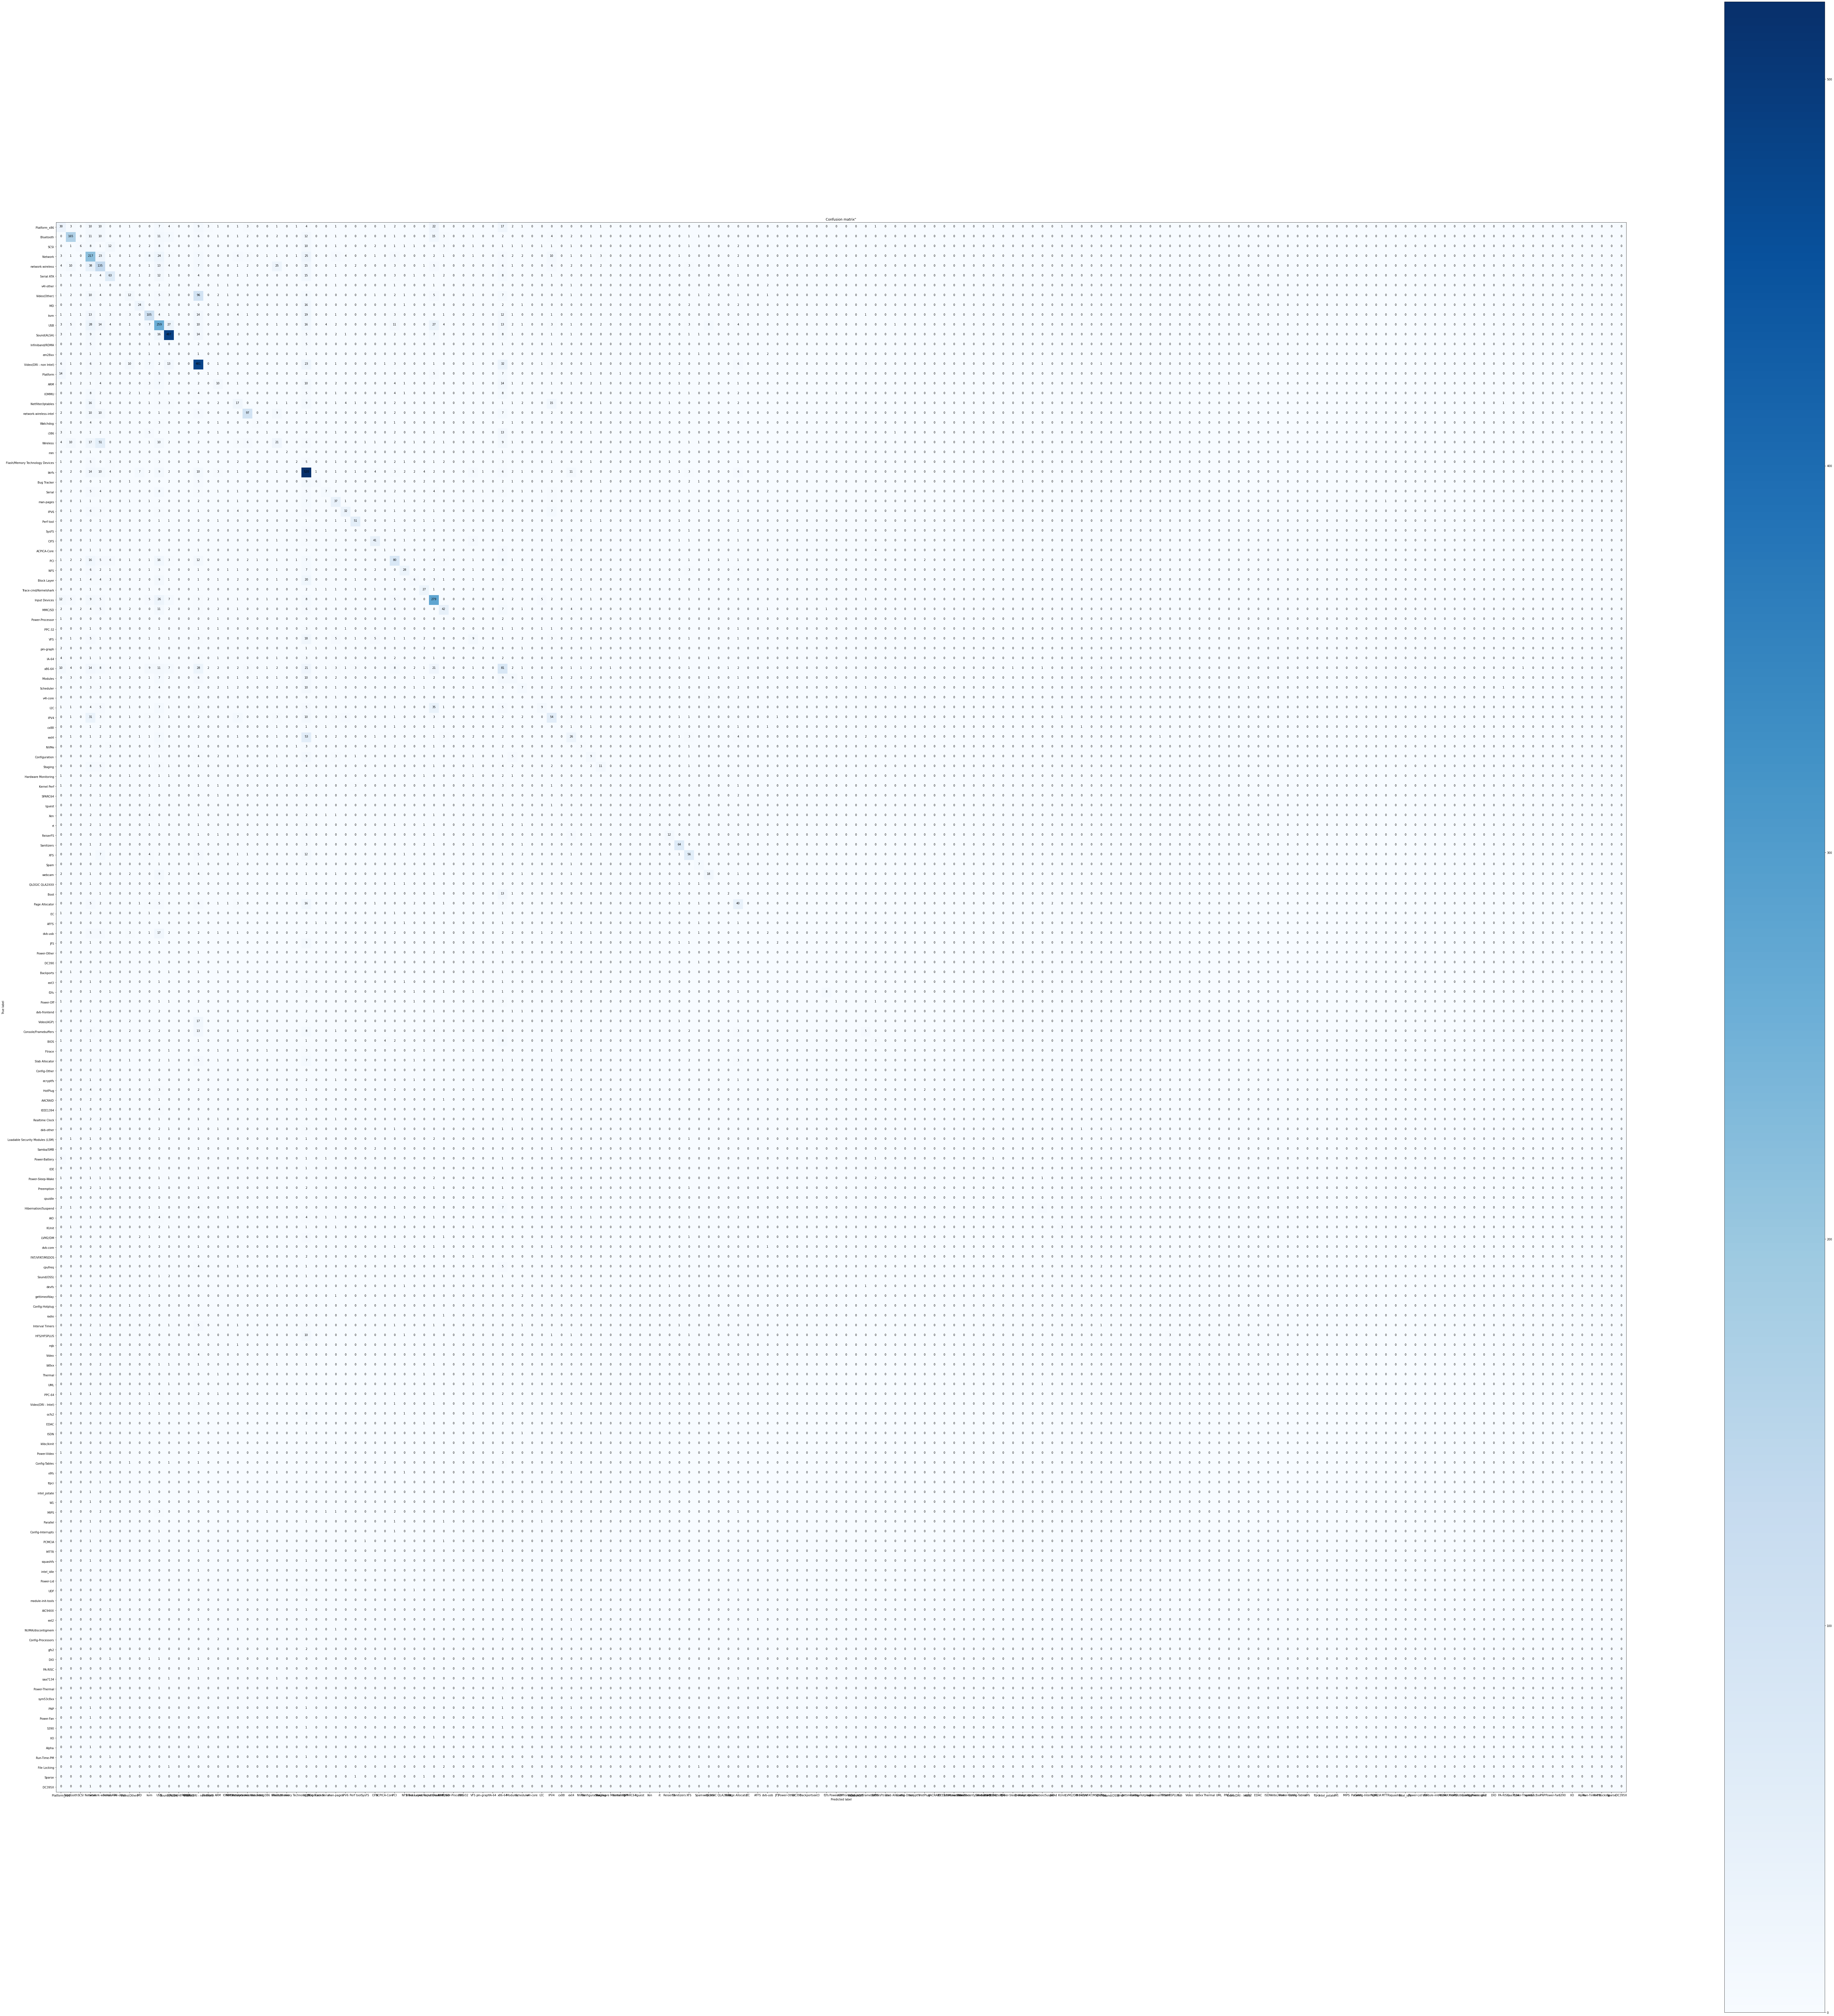

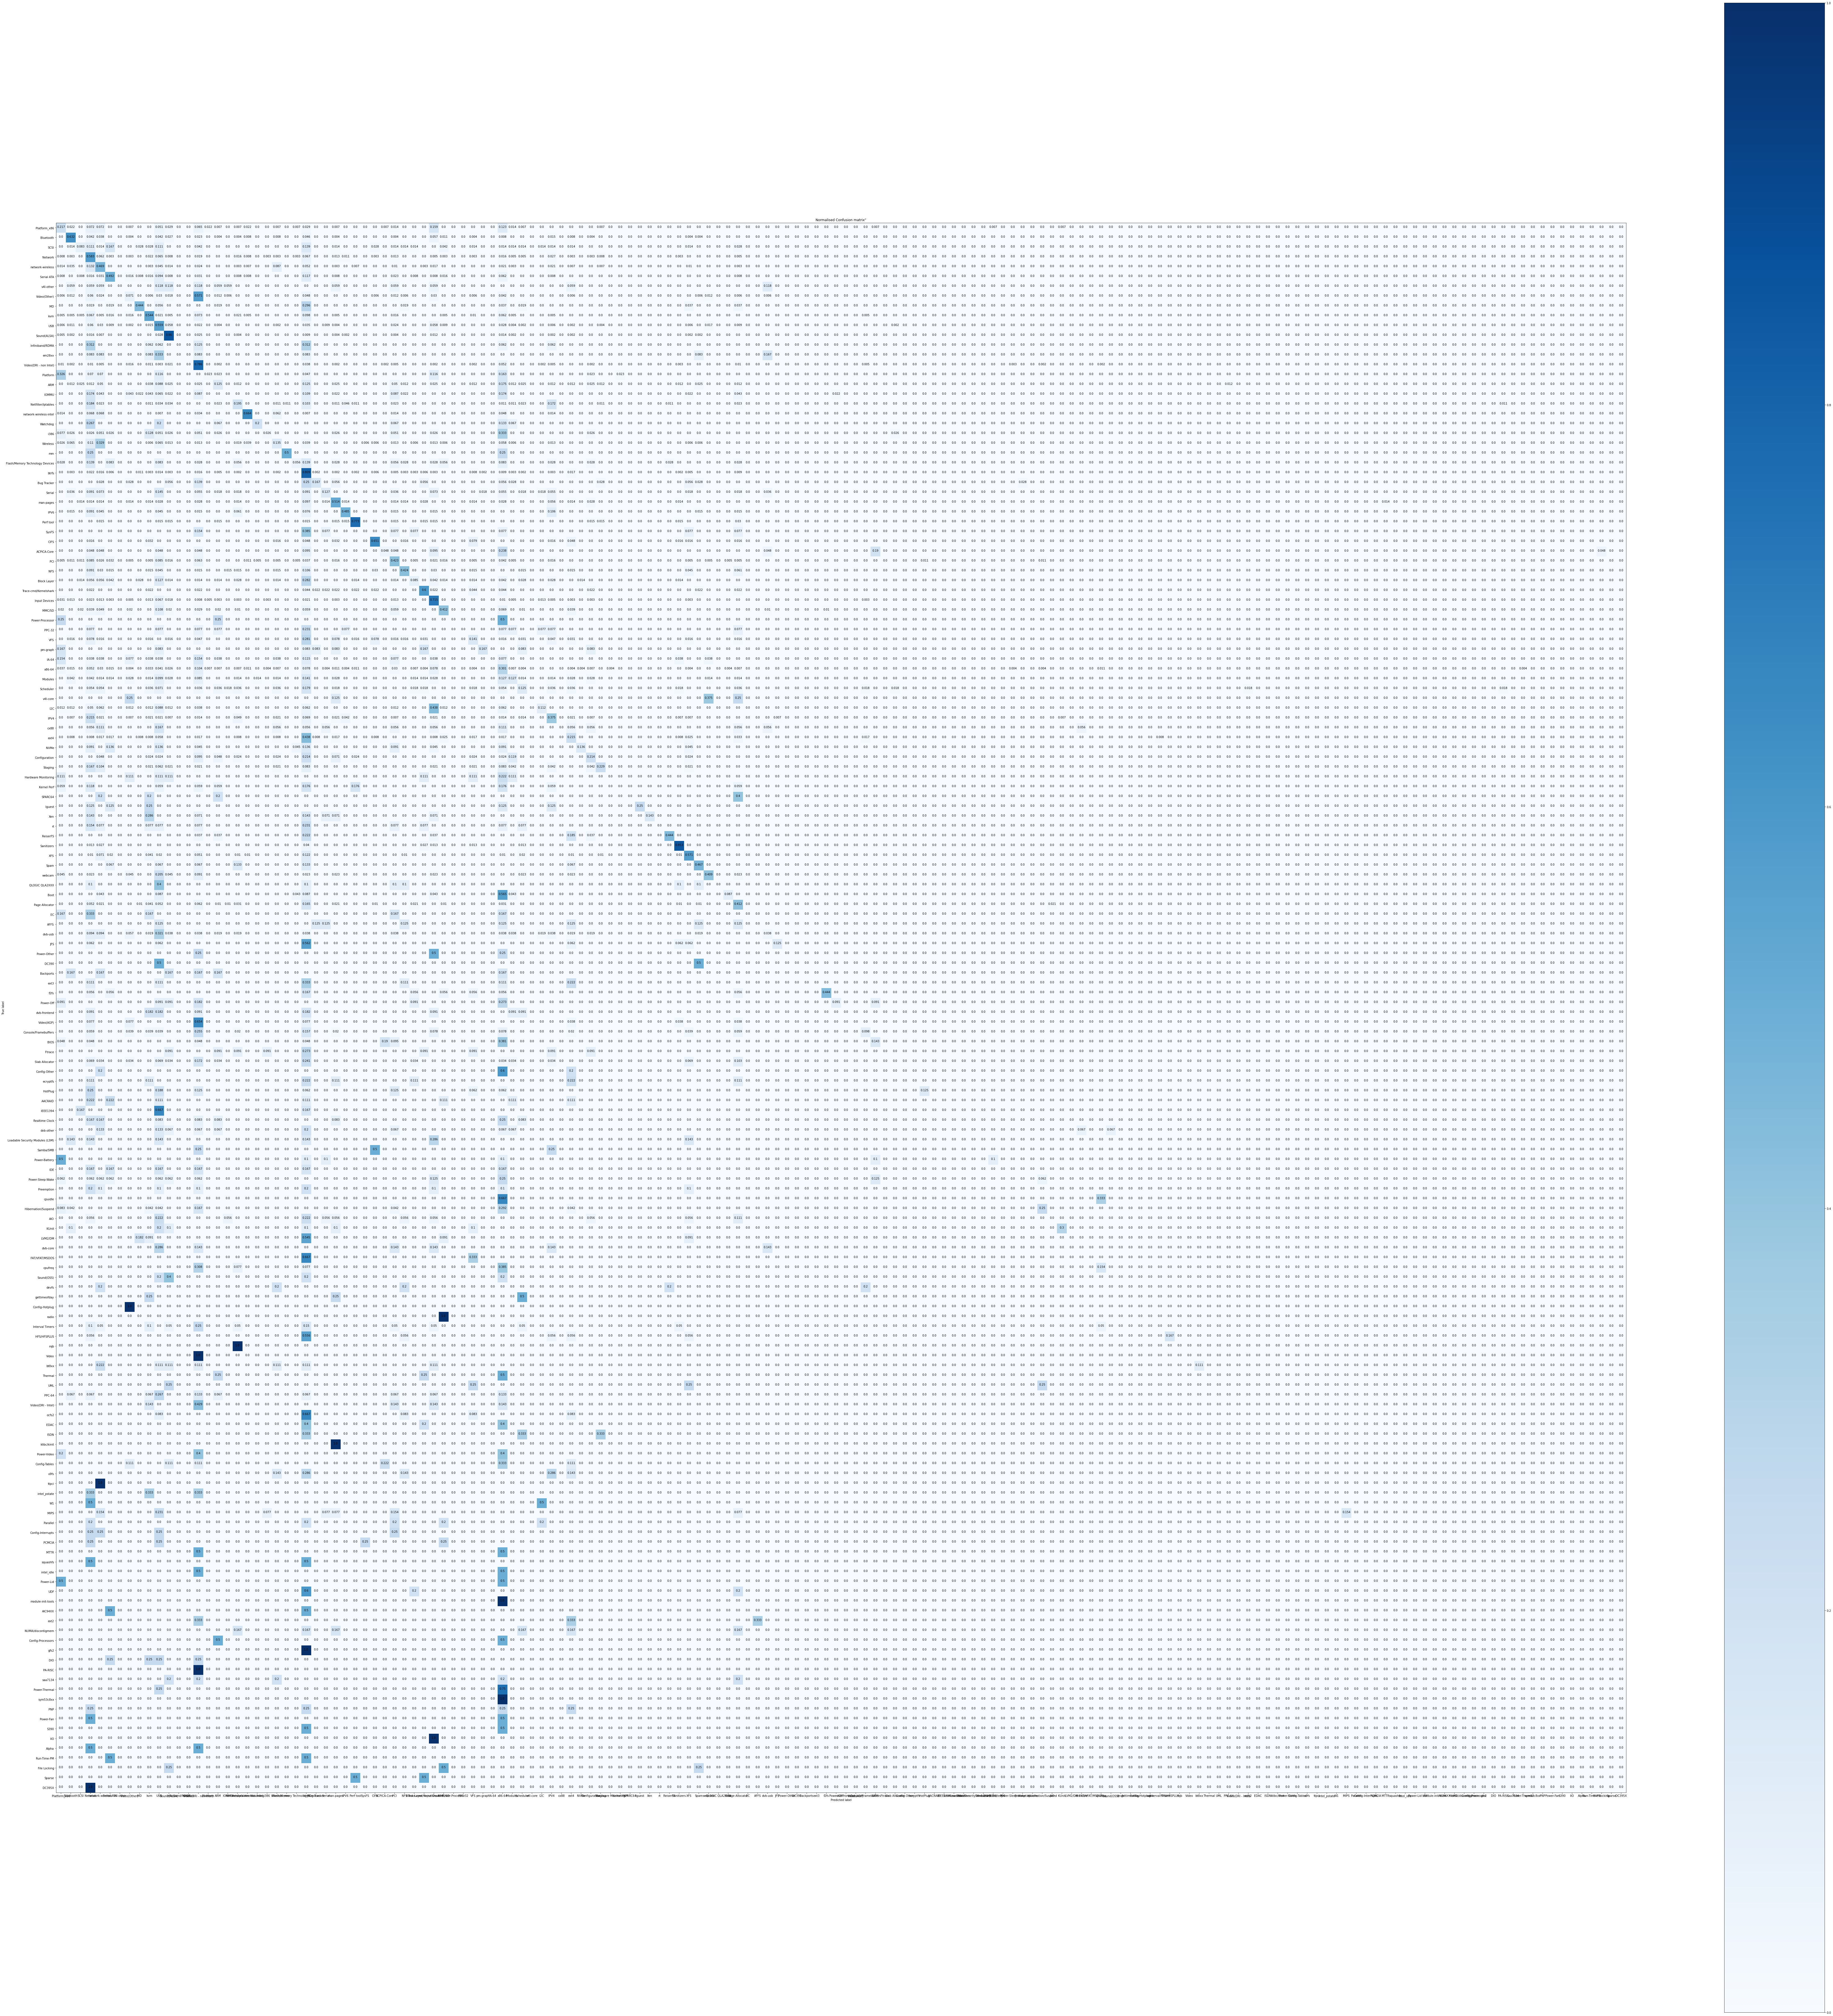

In [30]:
preds = oof_preds.argmax(axis = 1)
print("Accuracy: {:.2f}".format(metrics.accuracy_score(train_data['labels'], preds)))
print("Confusion Matrix")
fig, ax = plt.subplots(figsize=(100, 100))




plot_confusion_matrix(metrics.confusion_matrix(train_data['labels'], preds),
                          class_names,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues)




fig, ax = plt.subplots(figsize=(100, 100))
cm = metrics.confusion_matrix(train_data['labels'], preds, normalize = 'true').round(3)
plot_confusion_matrix(cm,
                          class_names,
                          title = 'Normalised Confusion matrix"',
                          cmap = plt.cm.Blues)
